In [1]:
# toc
import control as ct
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.integrate import solve_ivp, cumulative_trapezoid

plt.style.use('../maroon_ipynb.mplstyle')

# Problem 1
## Given
![Figure 1](fig1.png)

The constants from the above figure are given as follows:

$$
\begin{gathered}
r = 0.05\, m\\
k_1 = 1000\, N/m\\
k_2 = 500\, N/m \\
b = 100\, N\cdot s/m \\
B = 2.5\, N\cdot m\cdot s \\
J_1 = J_2 = 1\, kg\cdot m^2 \\
m = 1\, kg
\end{gathered}
$$

## Find
With the above system,

a. Develop a set of state variable equations. Define the state variable using the general matrix form: $\dot{S}=A\cdot S + B\cdot U$, where $A$ and $B$ are matrices and $S$ is a vector of state variables and $U$ is a vector of inputs. Be careful with labeling since one of the damping coefficients is also labeled $B$ in the figure.
b. Solve the state variable equations using a 4th order Runge-Kutta numerical method for a total simulation time of 20 seconds and assuming that all initial velocities and spring forces are zero and that $f(t)=10\,N$. Make sure the check that the number of points used in the simulation is adequate.
c. Verify your results using energy conservation. Show that at a given time, $t$, the total energy that has crossed the boundary through inputs and dampers is equal to the total energy stored in the system through mass/inertias and springs.
d. Use the output matrix form $Y=C\cdot S + D\cdot U$, where $Y$ is the chosen output and $C$ and $D$ are matrices. Use this form to define the contact force between the rack and the pinion using state variable simulation results. Then plot the contact force.
e. Find the input-output equation between the input force and the contact force. One approach of doing this is the use the `ss2tf` function in the `scipy.signal` module.
f. Use the laplace transform approach to solve the input-output equation and compare with results from part d. Comment on how the roots of the characteristic polynomial affect the response.

## Solution
### Part A
From the above figure, the massless element is denoted as $x_1$ and the mass denoted by $m$ is $x_2$.

In [2]:
# Define symbols
r, k1, k2, b, B, J1, J2, m, t, s = sp.symbols('r k1 k2 b B J1 J2 m t s', real=True, positive=True)
th1, th2 = sp.Function('theta_1')(t), sp.Function('theta_2')(t)
x1, x2 = sp.Function('x1')(t), sp.Function('x2')(t)
f, F_c = sp.Function('f')(t), sp.Function('F_c')(t)

# Construct equations
eq1 = sp.Eq(0, f - F_c - b*x1.diff() + k1*(x2 - x1))
eq2 = sp.Eq(m*x2.diff(t, 2), k1*(x1 - x2))
eq3 = sp.Eq(J1*th1.diff(t, 2), F_c*r + k2*(th2 - th1))
eq4 = sp.Eq(J2*th2.diff(t, 2), k2*(th1 - th2) - B*th2.diff())
eq5 = sp.Eq(x1.diff(t, 2), r*th1.diff(t, 2))
eqs = [eq1, eq2, eq3, eq4, eq5]
display(*eqs)

Eq(0, -b*Derivative(x1(t), t) + k1*(-x1(t) + x2(t)) - F_c(t) + f(t))

Eq(m*Derivative(x2(t), (t, 2)), k1*(x1(t) - x2(t)))

Eq(J1*Derivative(theta_1(t), (t, 2)), k2*(-theta_1(t) + theta_2(t)) + r*F_c(t))

Eq(J2*Derivative(theta_2(t), (t, 2)), -B*Derivative(theta_2(t), t) + k2*(theta_1(t) - theta_2(t)))

Eq(Derivative(x1(t), (t, 2)), r*Derivative(theta_1(t), (t, 2)))

Let's clean this up a little by considering the velocities $v_1$, $v_2$, $\omega_1$, and $\omega_2$. Also, let's omit considering the coordinate positions in the system and only look to the displacements of the compliance elements. I will define $\Delta x$ and $\Delta\theta$ as

$$\begin{cases}
\Delta x = x_2 - x_1 \\
\Delta\theta = \theta_2 - \theta_1
\end{cases}$$

In [3]:
d_theta = sp.Function(r'\Delta\theta')(t)
d_x = sp.Function(r'\Delta x')(t)

v1, v2 = sp.Function('v1')(t), sp.Function('v2')(t)
omega1, omega2 = sp.Function(r'\omega_1')(t), sp.Function(r'\omega_2')(t)

subs = [
    (x2 - x1, d_x),
    (th2 - th1, d_theta),
    (x1.diff(), v1),
    (x2.diff(), v2),
    (th1.diff(), omega1),
    (th2.diff(), omega2)
]

eqs = [eq.subs(subs) for eq in eqs]
display(*eqs)

Eq(0, -b*v1(t) + k1*\Delta x(t) - F_c(t) + f(t))

Eq(m*Derivative(v2(t), t), -k1*\Delta x(t))

Eq(J1*Derivative(\omega_1(t), t), k2*\Delta\theta(t) + r*F_c(t))

Eq(J2*Derivative(\omega_2(t), t), -B*\omega_2(t) - k2*\Delta\theta(t))

Eq(Derivative(v1(t), t), r*Derivative(\omega_1(t), t))

Now we can solve this system for $\dot{v}_1$, $\dot{v}_2$, $\dot{\omega}_1$ $\dot{\omega}_2$. Additionally, I will solve for $F_c$ to be used later.

In [4]:
state_sol = sp.solve(eqs, (v1.diff(), v2.diff(), omega1.diff(), omega2.diff(), F_c), dict=True)[0]
for key, value in state_sol.items():
    display(sp.Eq(key, value))

Eq(F_c(t), -b*v1(t) + k1*\Delta x(t) + f(t))

Eq(Derivative(\omega_1(t), t), -b*r*v1(t)/J1 + k1*r*\Delta x(t)/J1 + k2*\Delta\theta(t)/J1 + r*f(t)/J1)

Eq(Derivative(\omega_2(t), t), -B*\omega_2(t)/J2 - k2*\Delta\theta(t)/J2)

Eq(Derivative(v1(t), t), -b*r**2*v1(t)/J1 + k1*r**2*\Delta x(t)/J1 + k2*r*\Delta\theta(t)/J1 + r**2*f(t)/J1)

Eq(Derivative(v2(t), t), -k1*\Delta x(t)/m)

Notice in the above solution that we don't have any terms that include $\omega_1$. This is due to the direct algebraic relationship and the order in which `sympy` solved the system. Therefore, we can ignore the $\dot{\omega}_1$ equation. Also, the solution for $F_c$ is not an ODE so it isn't directly a part of the state space solution.

In [5]:
# Getting the final five equations
eq1 = sp.Eq(d_x.diff(), v2 - v1)
eq2 = sp.Eq(d_theta.diff(), omega2 - v1/r)
eq3 = sp.Eq(v1.diff(), state_sol[v1.diff()])
eq4 = sp.Eq(v2.diff(), state_sol[v2.diff()])
eq5 = sp.Eq(omega2.diff(), state_sol[omega2.diff()])
eqs = [eq1, eq2, eq3, eq4, eq5]
display(*eqs)

Eq(Derivative(\Delta x(t), t), -v1(t) + v2(t))

Eq(Derivative(\Delta\theta(t), t), \omega_2(t) - v1(t)/r)

Eq(Derivative(v1(t), t), -b*r**2*v1(t)/J1 + k1*r**2*\Delta x(t)/J1 + k2*r*\Delta\theta(t)/J1 + r**2*f(t)/J1)

Eq(Derivative(v2(t), t), -k1*\Delta x(t)/m)

Eq(Derivative(\omega_2(t), t), -B*\omega_2(t)/J2 - k2*\Delta\theta(t)/J2)

In [6]:
# Putting it in the state space form
S_dot = sp.Matrix([eq.lhs for eq in eqs])
S = S_dot.integrate(t)
rhs = [eq.rhs for eq in eqs]
A, b_sym = sp.linear_eq_to_matrix(rhs, list(S))
B_sym = -b_sym/f
U = sp.Matrix([f])
ans = sp.Eq(S_dot, sp.Add(sp.MatMul(A, S), sp.MatMul(B_sym, U)))  # doing this makes it not simplify
ans

Eq(Matrix([
[    Derivative(\Delta x(t), t)],
[Derivative(\Delta\theta(t), t)],
[          Derivative(v1(t), t)],
[          Derivative(v2(t), t)],
[    Derivative(\omega_2(t), t)]]), Matrix([
[      0],
[      0],
[r**2/J1],
[      0],
[      0]])*Matrix([[f(t)]]) + Matrix([
[         0,       0,         -1, 1,     0],
[         0,       0,       -1/r, 0,     1],
[k1*r**2/J1, k2*r/J1, -b*r**2/J1, 0,     0],
[     -k1/m,       0,          0, 0,     0],
[         0,  -k2/J2,          0, 0, -B/J2]])*Matrix([
[    \Delta x(t)],
[\Delta\theta(t)],
[          v1(t)],
[          v2(t)],
[    \omega_2(t)]]))

### Part B
All we need to do is construct a python function that will return the right hand side of the equation above.

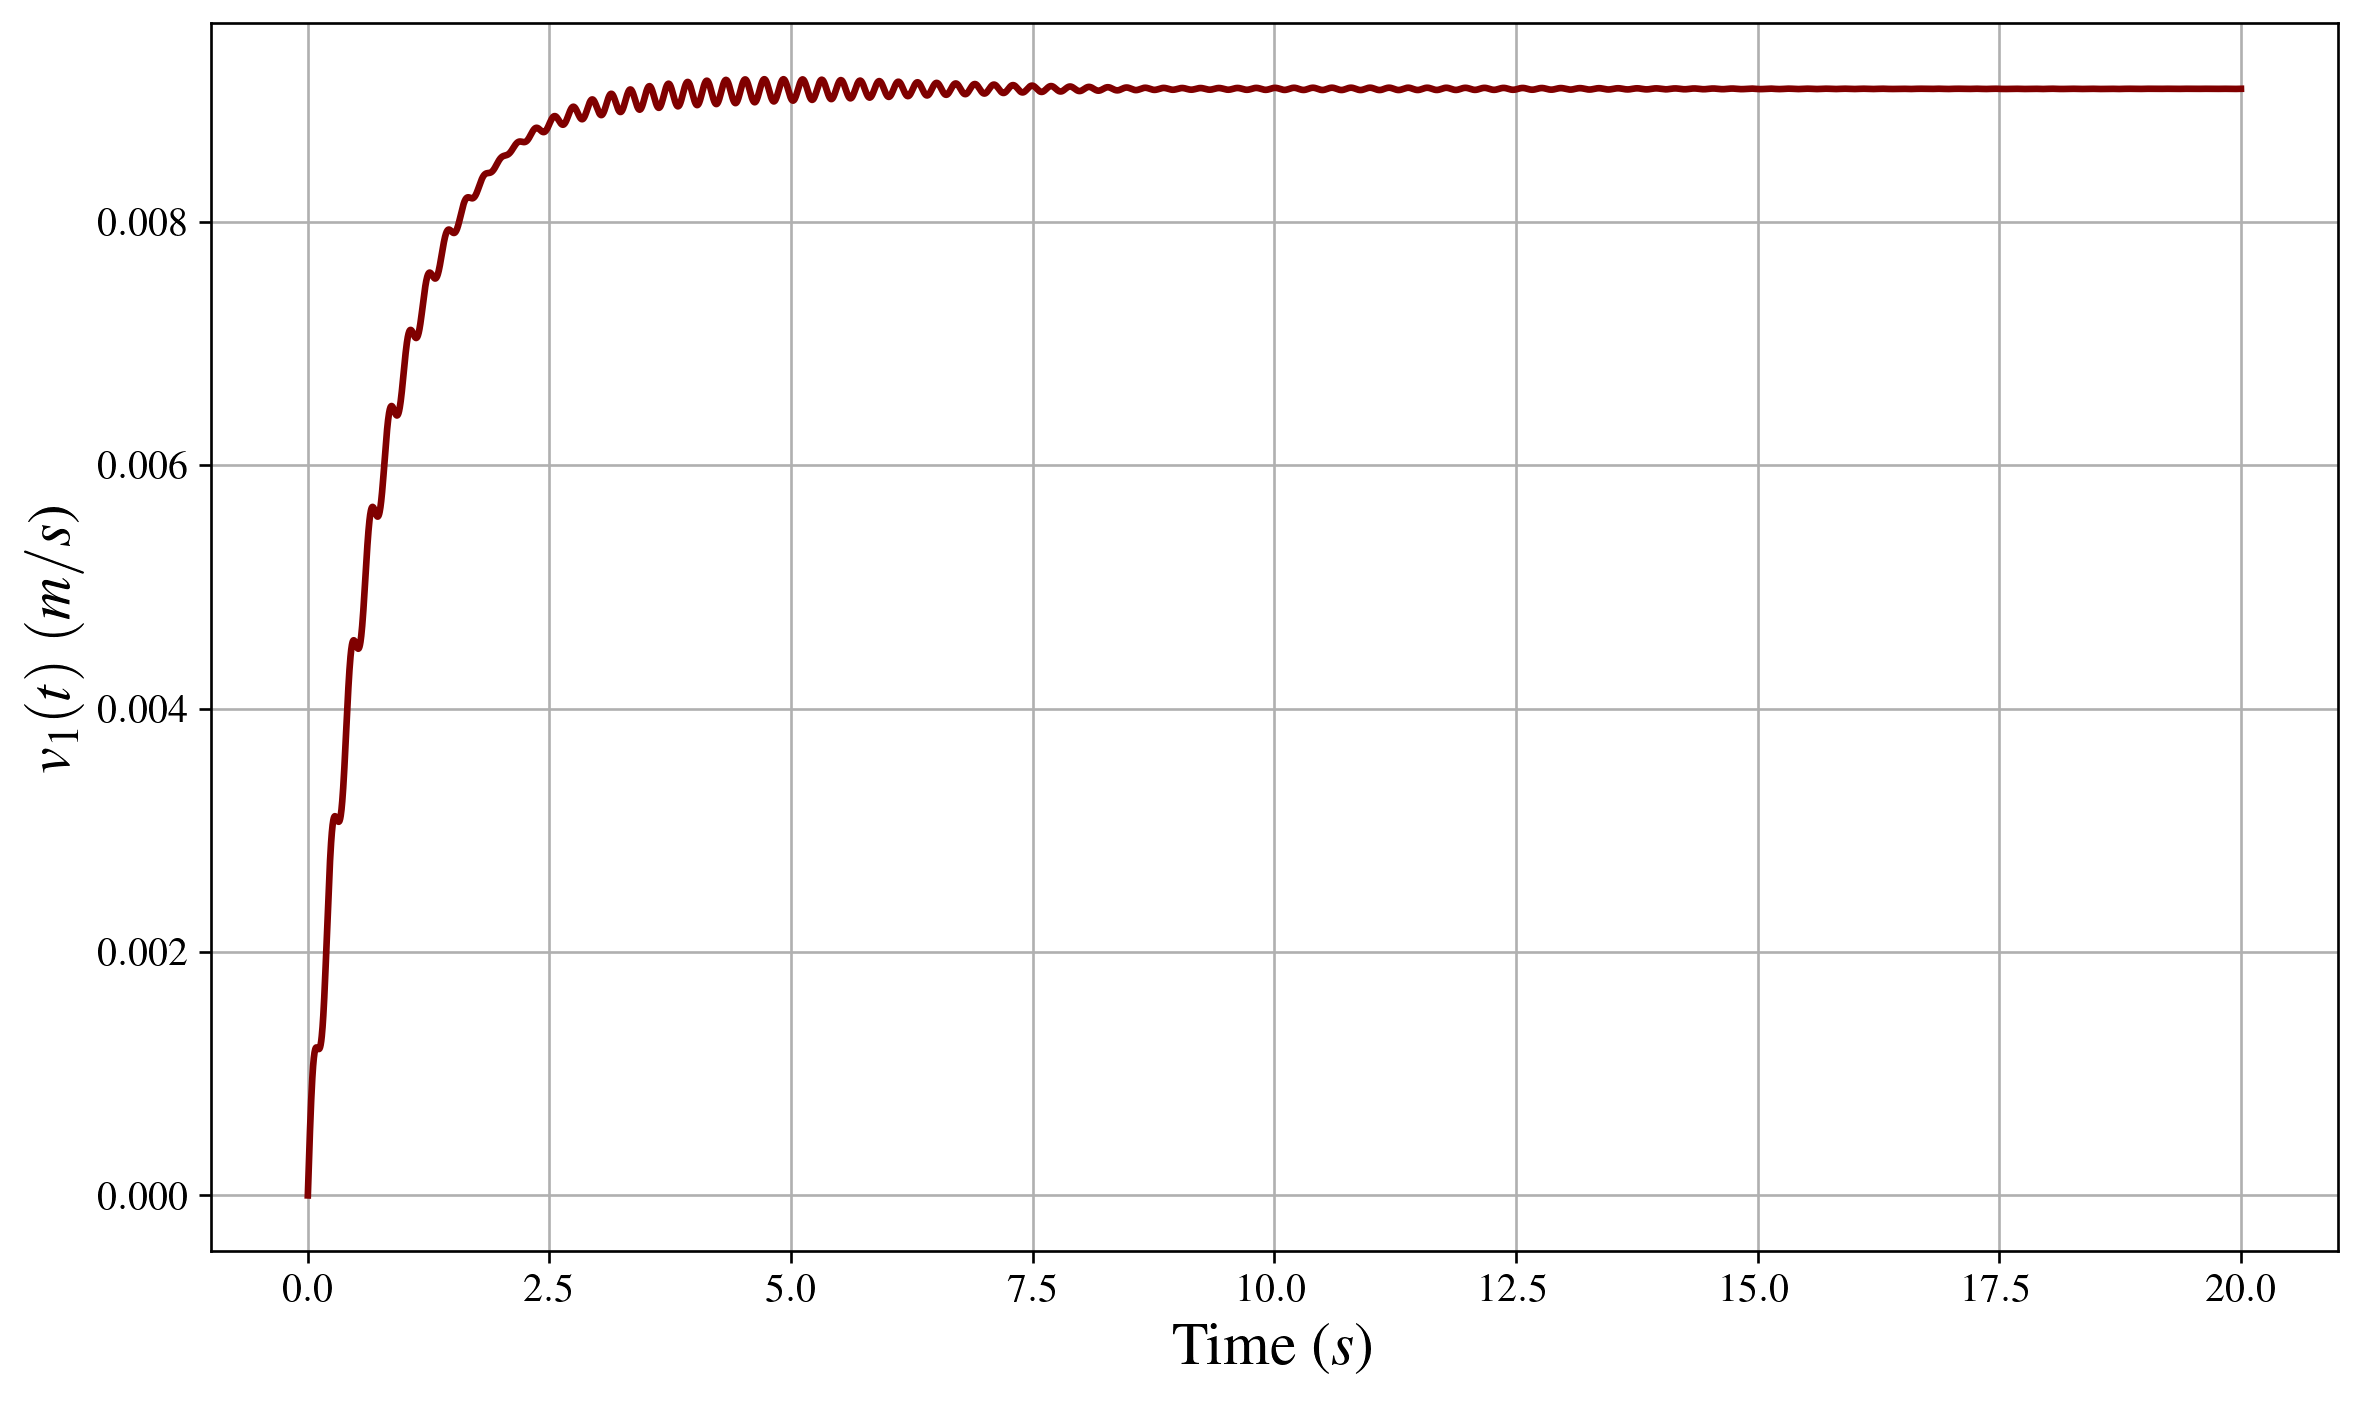

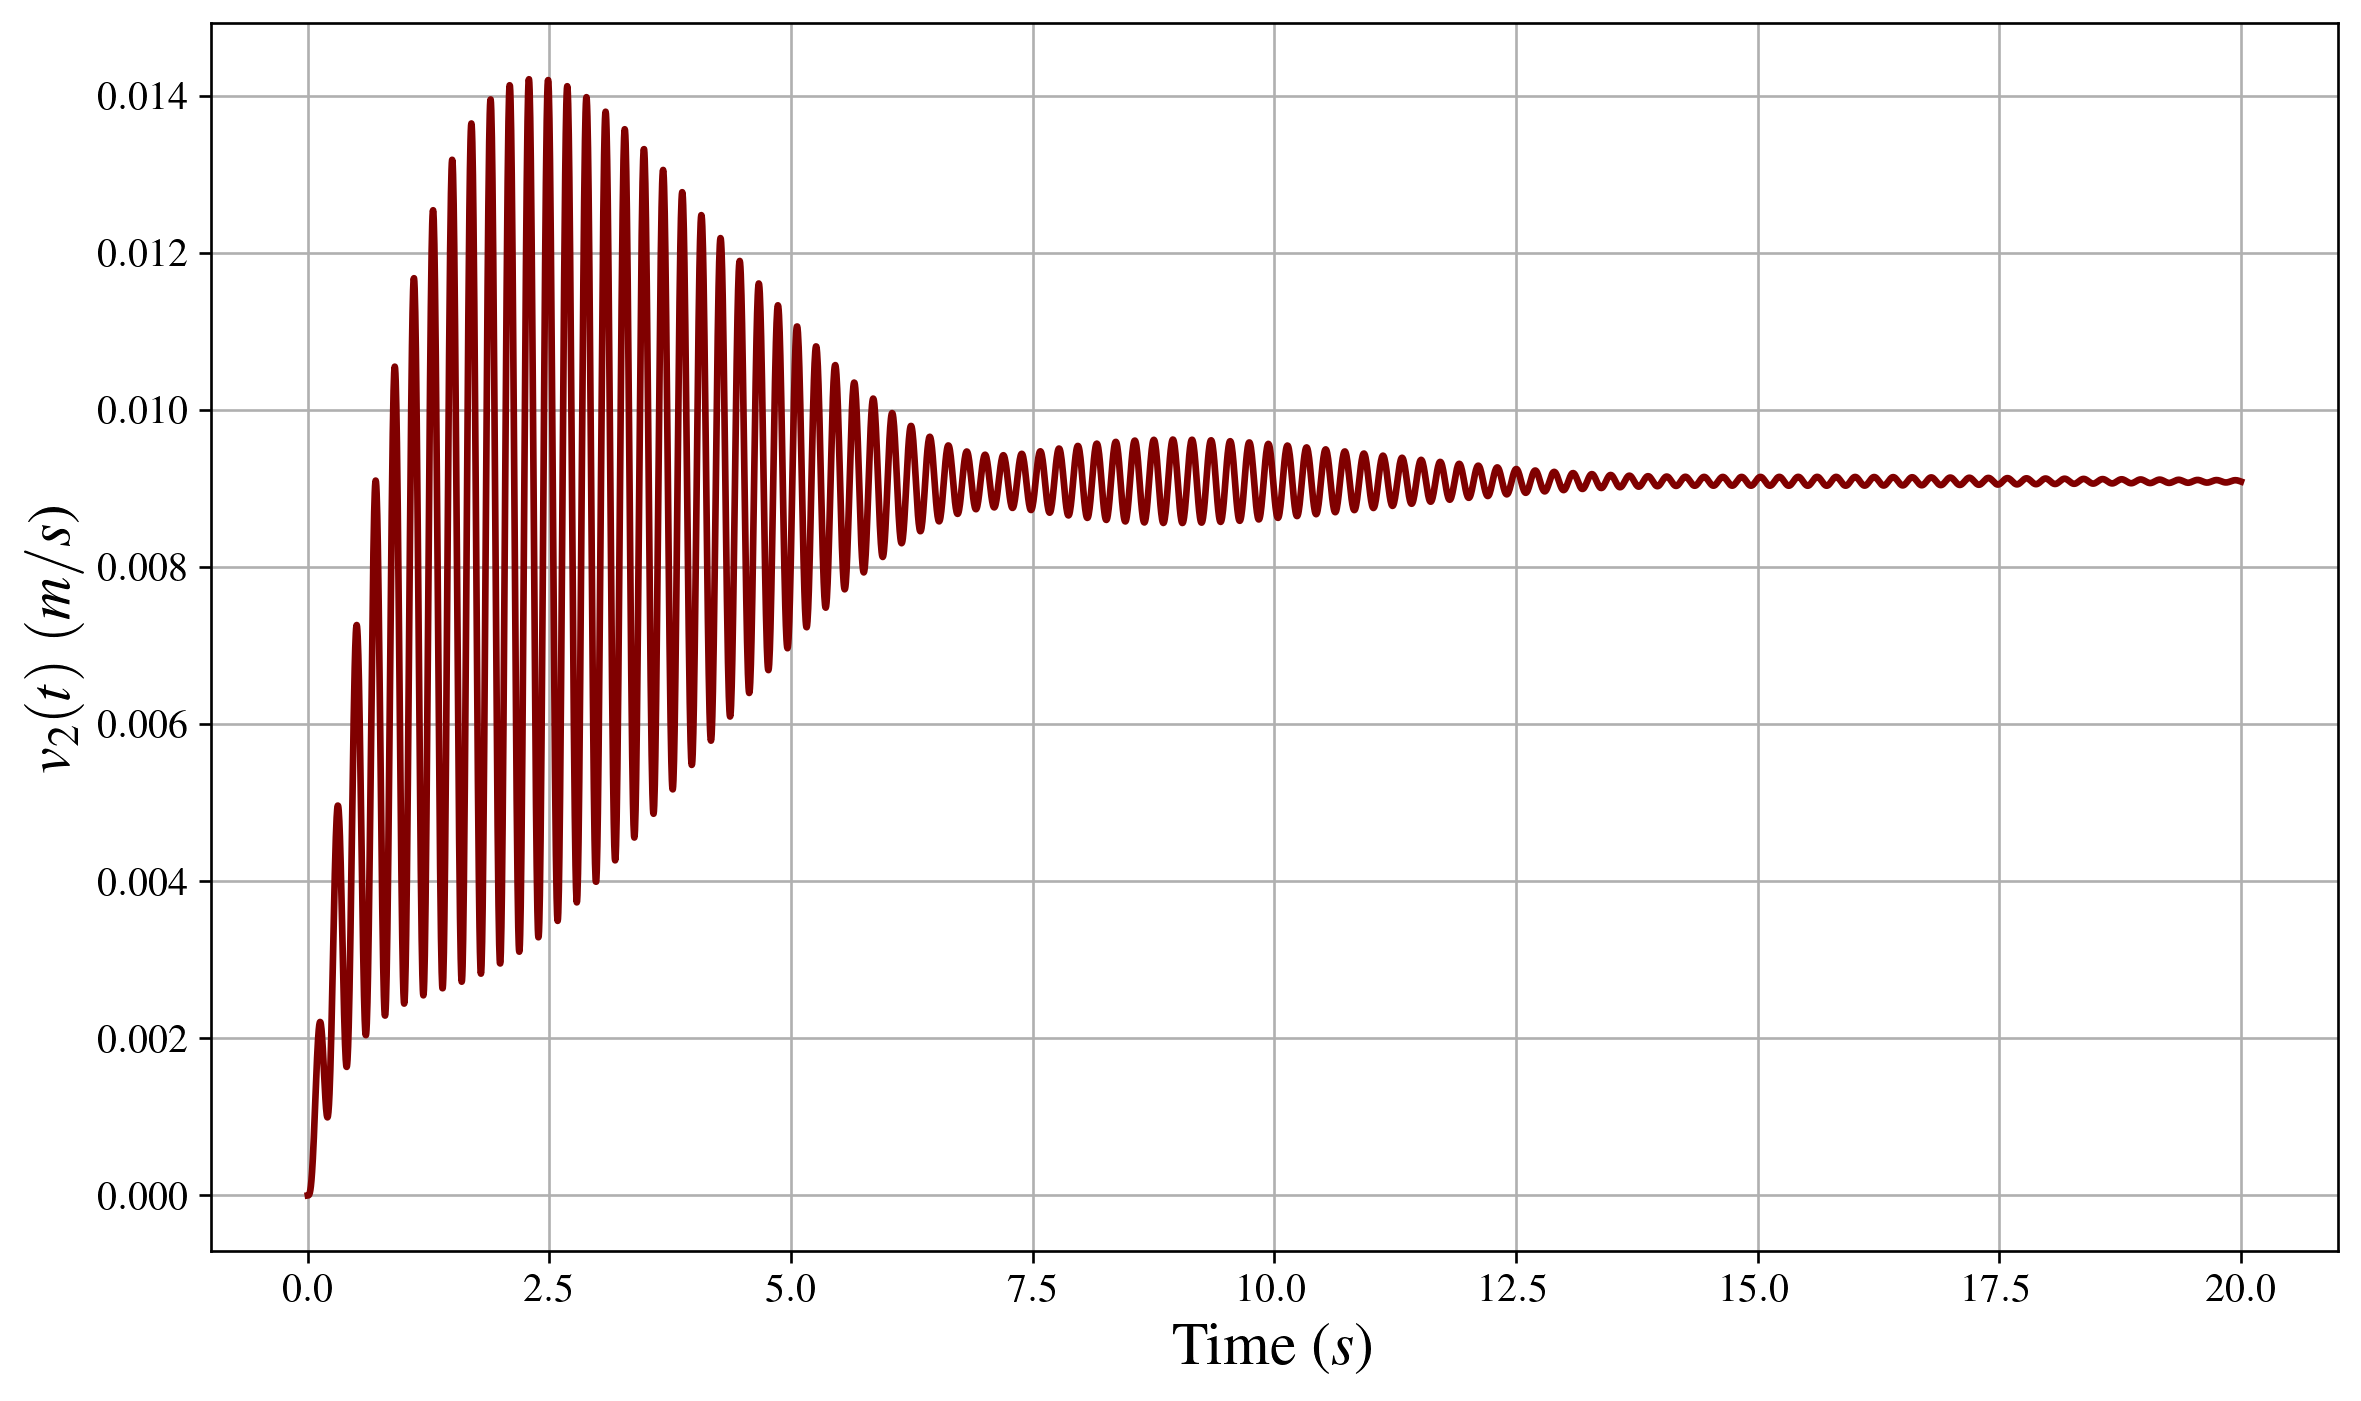

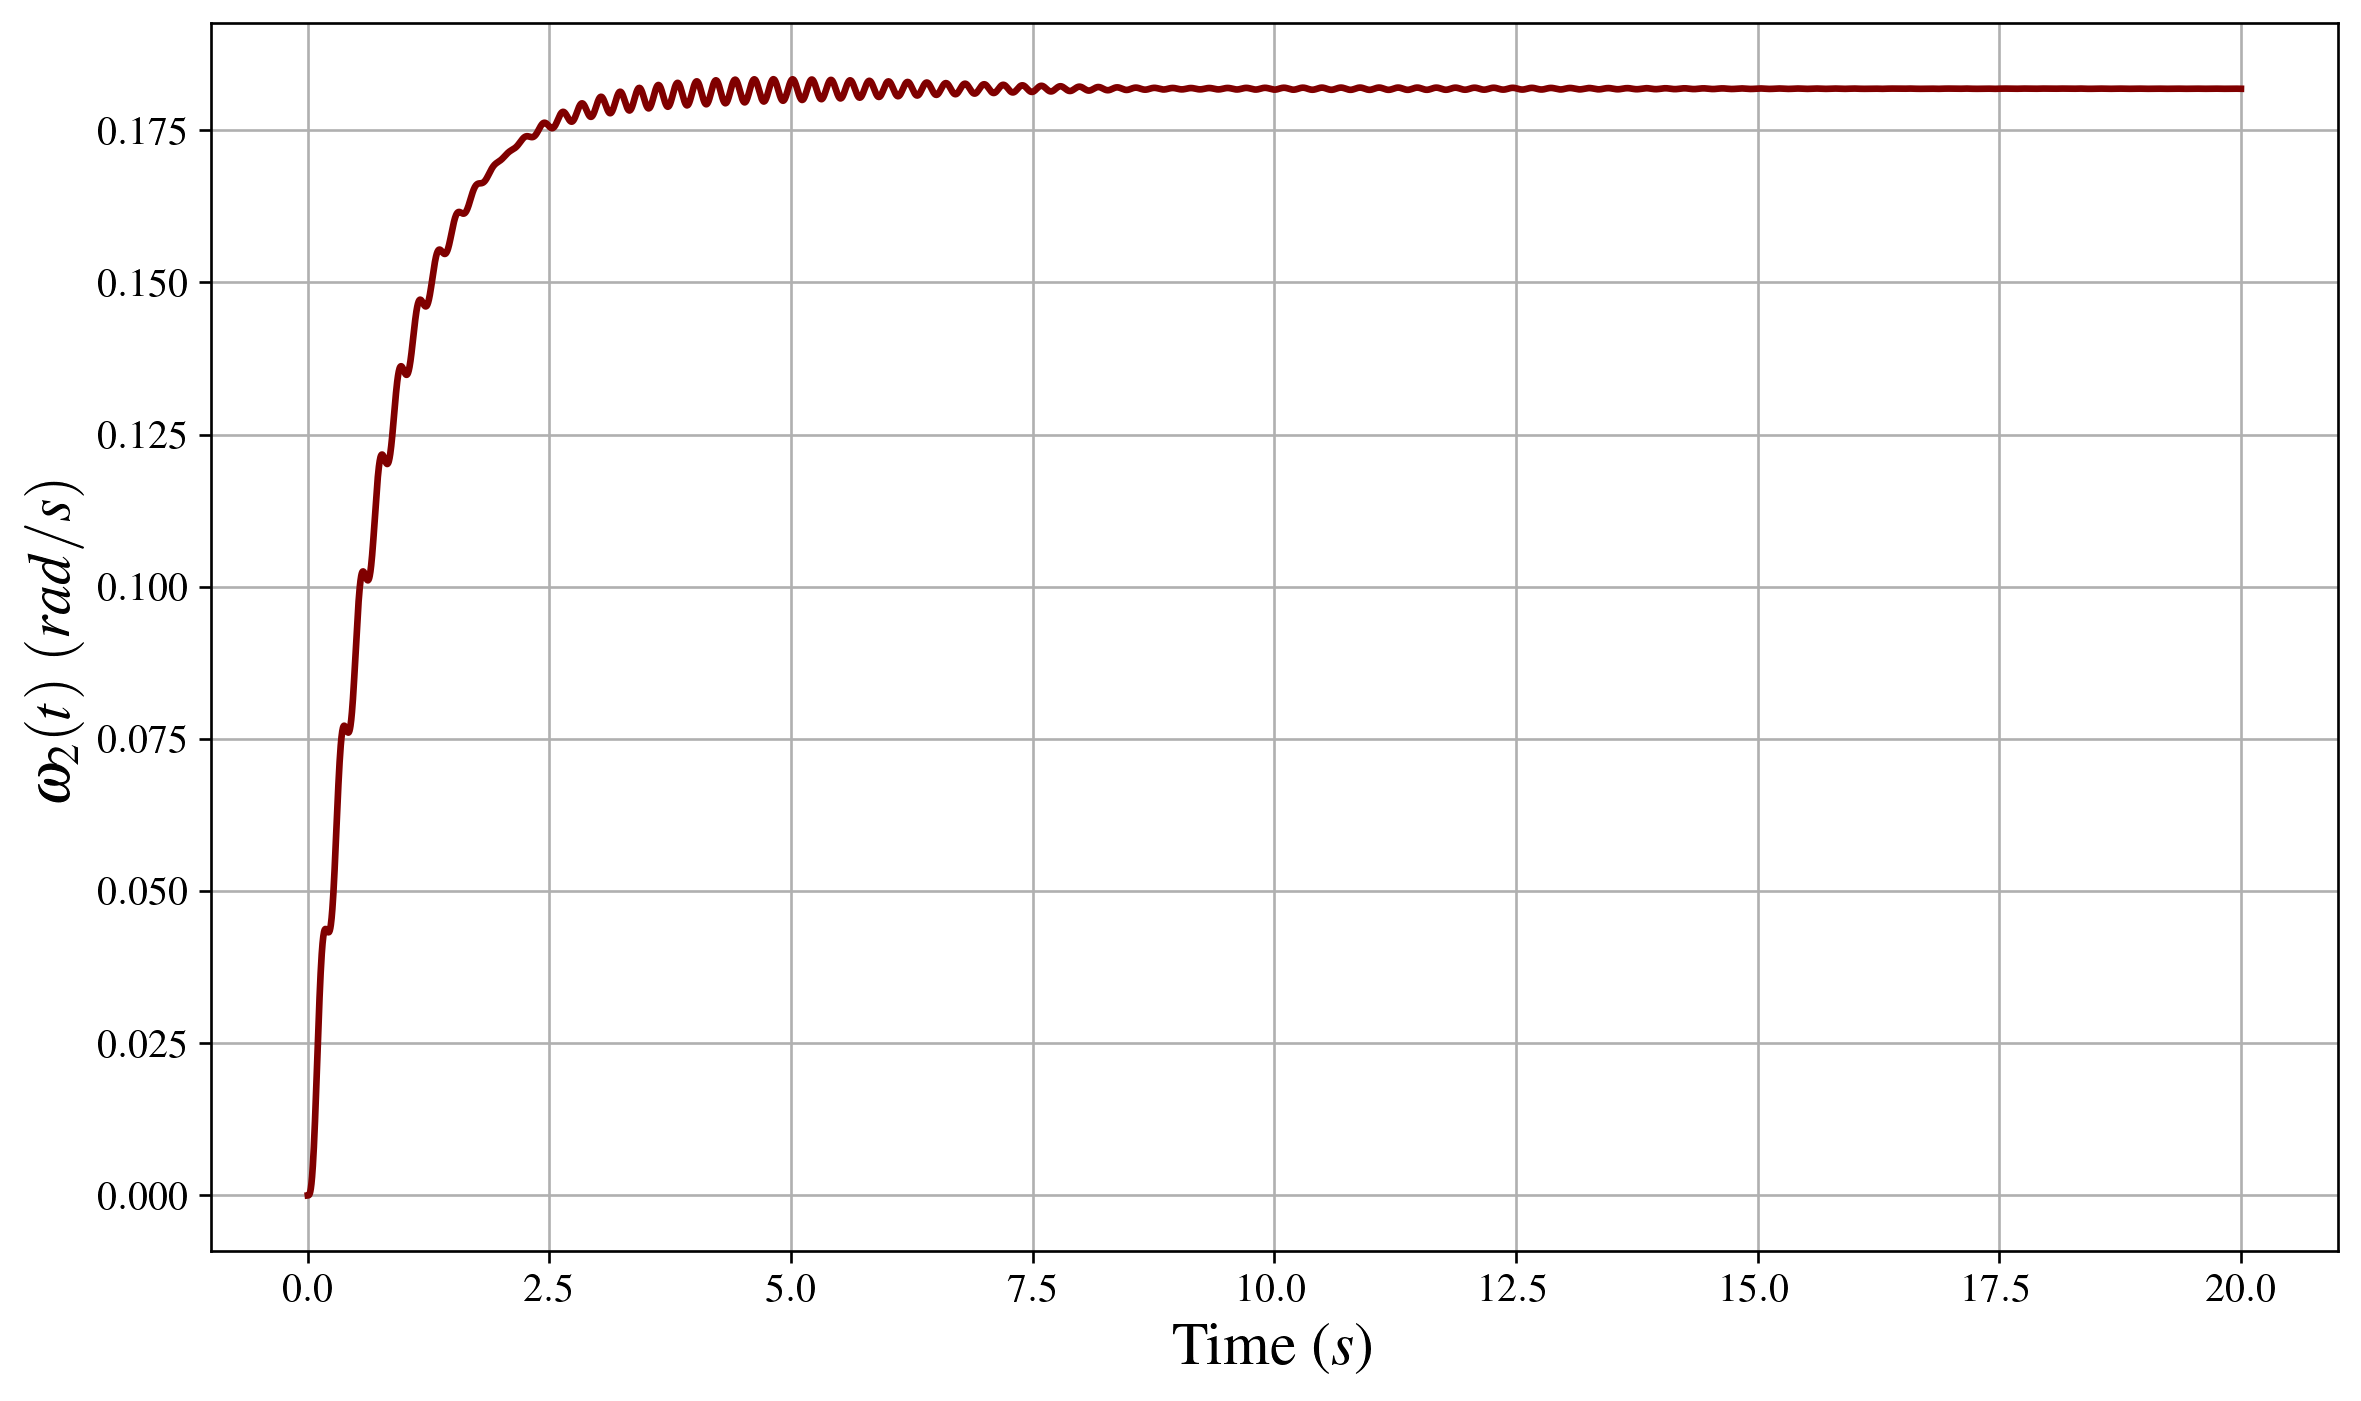

In [7]:
r_ = 0.05
k1_ = 1000
k2_ = 500
b_ = 100
B_num = 2.5
J1_ = J2_ = 1
m_ = 1

sub_vals = [
    (r, sp.Rational(5, 100)),
    (k1, k1_),
    (k2, k2_),
    (b, b_),
    (B, sp.Rational(5, 2)),
    (J1, J1_),
    (J2, J2_),
    (m, m_)
]
f_lamb = lambda t_: 10

A_ = np.float64(A.subs(sub_vals))
B_ = np.float64(B_sym.subs(sub_vals)).flatten()

def state_vars(t_, y):
    return A_@y + B_*f_lamb(t_)

sol1 = solve_ivp(state_vars, (0, 20), [0]*5, method='RK45', rtol=1e-9, atol=1e-12)

for i in range(2, 5):
    fig, ax = plt.subplots()
    ax.plot(sol1.t, sol1.y[i])

    unit = '$(m/s$)' if i != 4 else '$(rad/s)$'

    label = sp.latex(list(S)[i])
    ax.set_ylabel(f'${label}$ {unit}')
    ax.set_xlabel(f'Time ($s$)')
    plt.show()

The above uses `scipy`'s RK45 solver, which is more convenient for determining the correct step size. Also, I am only showing the solutions for the velocities as they have more meaning than the displacements. This is why I'm a fan of not combining the state variables into a displacement, but this method is easier to do by hand and has fewer equations.

## Verification of Parts A-B
### Part C
We can further verify the results by testing to see if the energy was conserved with the following relationship:

$$E_{stored}(t)=E_{input}(t)-E_{output}(t)$$

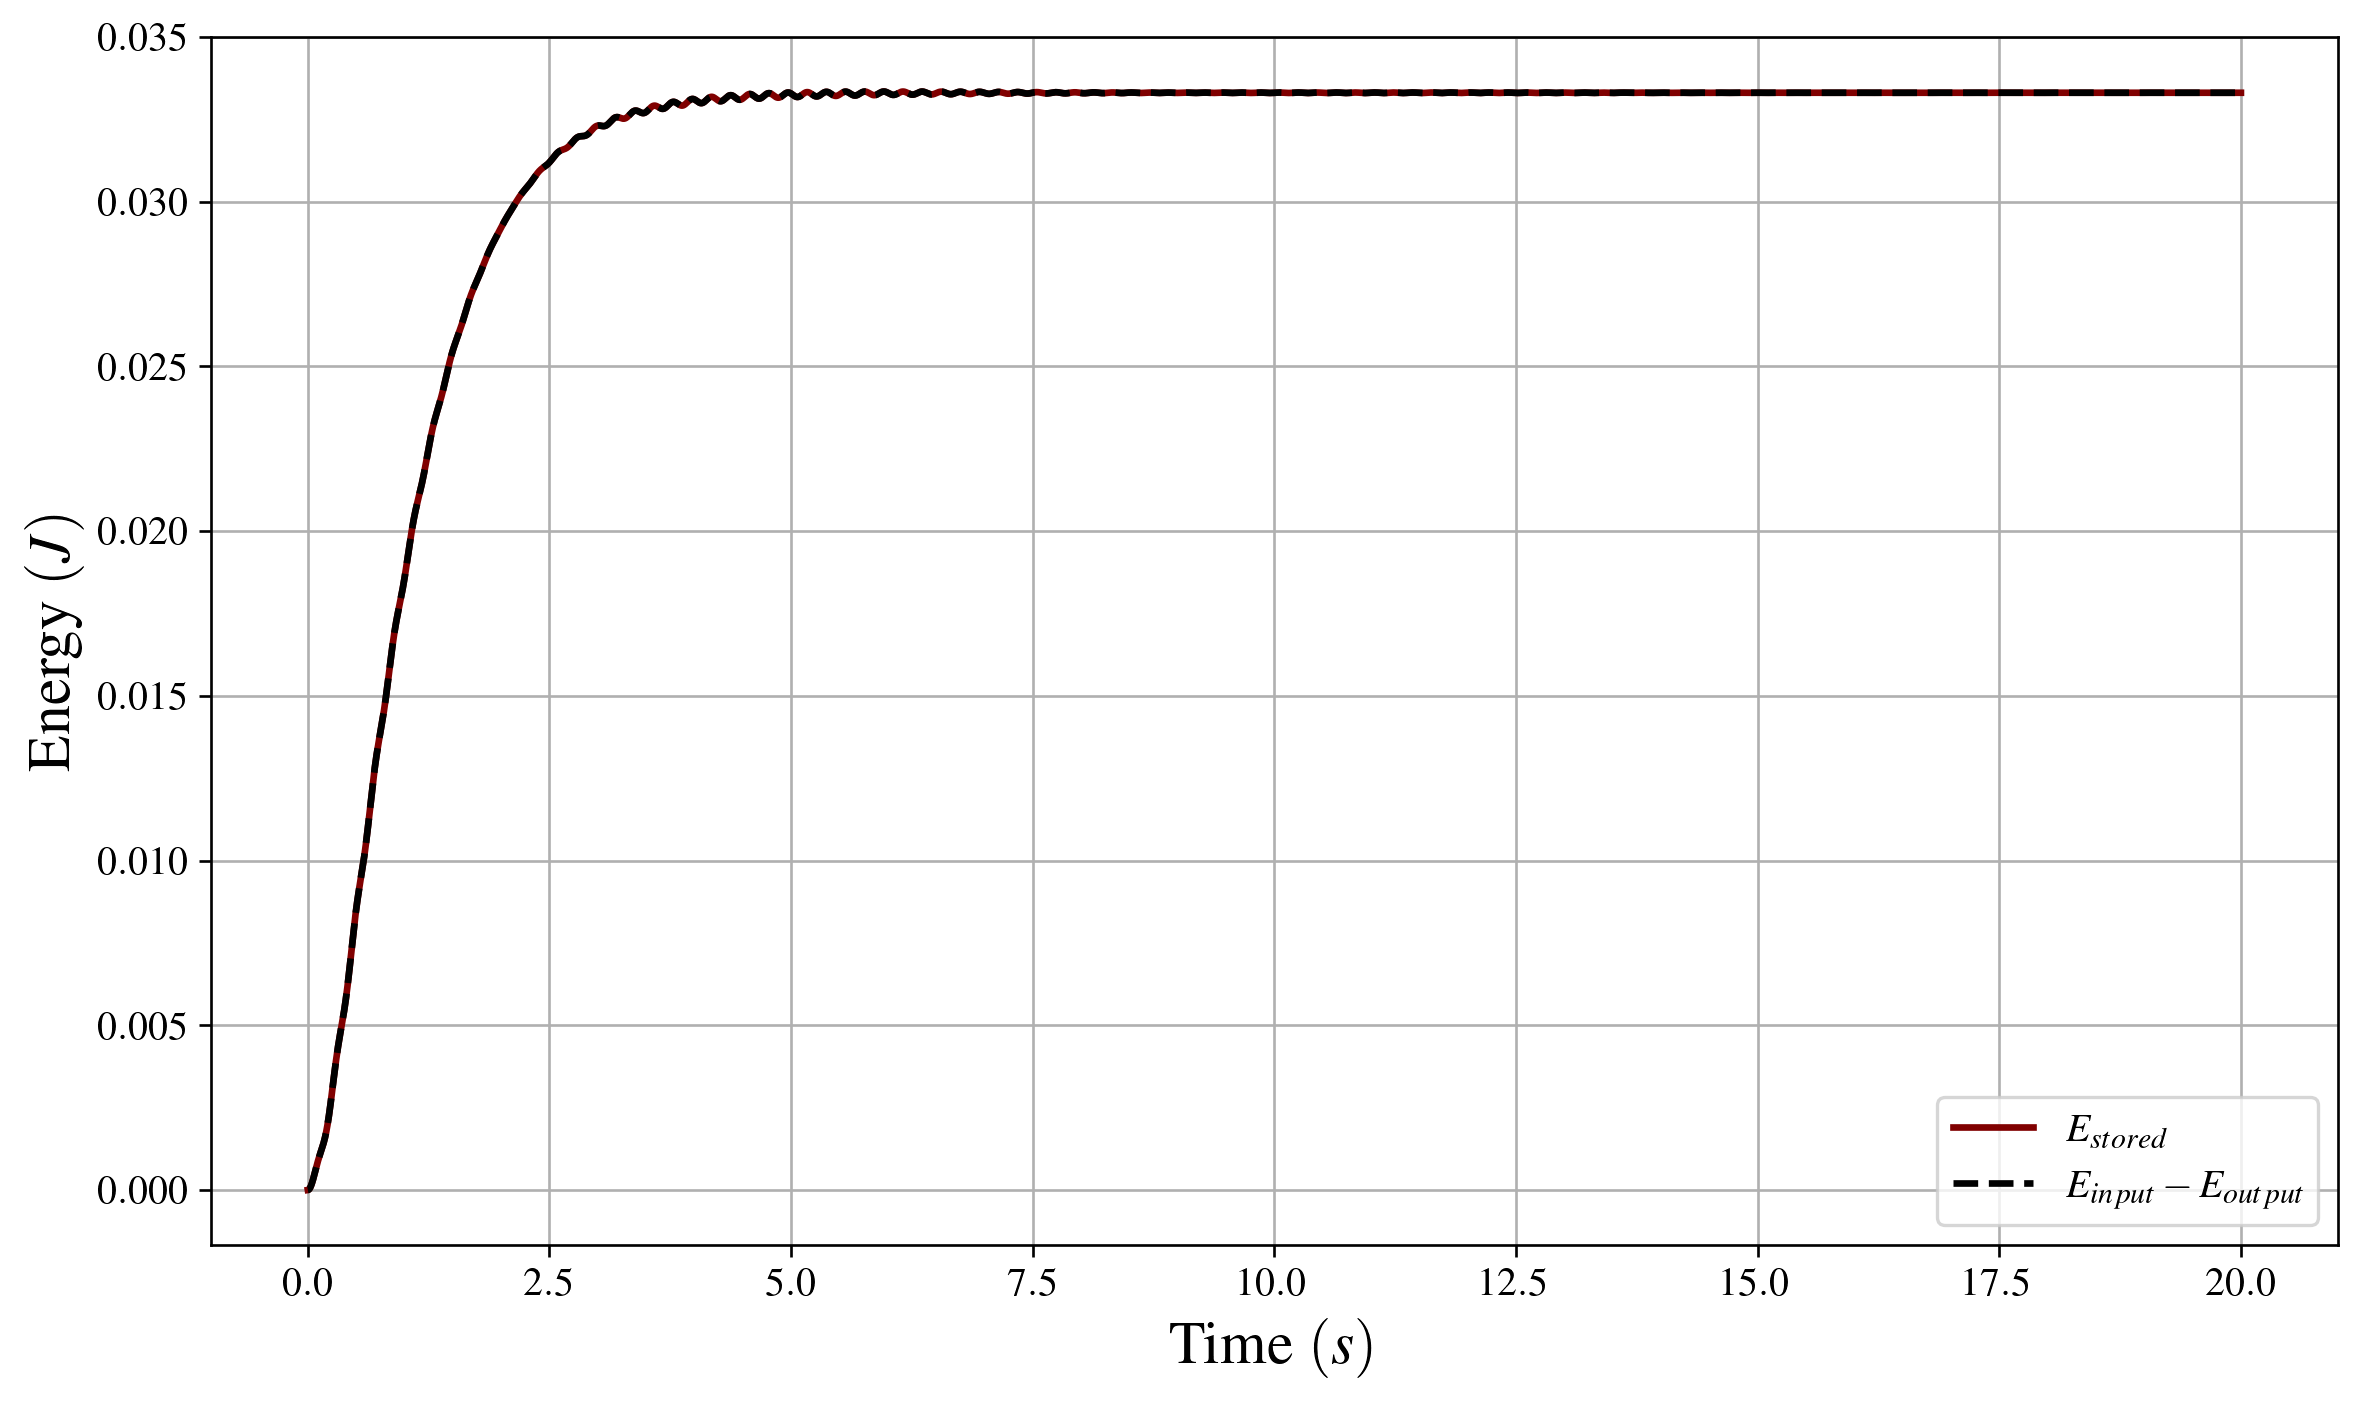

In [8]:
d_x_, d_theta_, v1_, v2_, omega2_ = sol1.y

# Kinetic energy
KE = (
    1/2*(J1_/r_**2)*v1_**2 +
    1/2*m_*v2_**2 +
    1/2*J2_*omega2_**2
)

PE = (
    1/2*k1_*d_x_**2 +
    1/2*k2_*d_theta_**2
)
E_stored = KE + PE

# input power
P_input = f_lamb(sol1.t)*v1_
E_input = cumulative_trapezoid(P_input, sol1.t, initial=0)

# output power
P_output = b_*v1_**2 + B_num*omega2_**2
E_output = cumulative_trapezoid(P_output, sol1.t, initial=0)

fig, ax = plt.subplots()
ax.plot(sol1.t, E_stored, label=r'$E_{stored}$')
ax.plot(sol1.t, E_input - E_output, label=r'$E_{input}-E_{output}$', ls='--')
ax.set_xlabel('Time $(s)$')
ax.set_ylabel(r'Energy $(J)$')
ax.legend()
plt.show()

### Part D
You can see from the previous work that the contact force is

In [9]:
state_sol[F_c]

-b*v1(t) + k1*\Delta x(t) + f(t)

This means that you can represent $C$ and $D$ as 

$$
C = \begin{bmatrix}
k_1 & 0 & -b & 0 & 0
\end{bmatrix}, \quad
D = \begin{bmatrix}
1
\end{bmatrix}.
$$

In [10]:
C = np.array([[k1_, 0, -b_, 0, 0]])
D = np.array([[1]])

ss = ct.ss(A_, B_.reshape(-1, 1), C, D)
ss

StateSpace(array([[ 0.0e+00,  0.0e+00, -1.0e+00,  1.0e+00,  0.0e+00],
       [ 0.0e+00,  0.0e+00, -2.0e+01,  0.0e+00,  1.0e+00],
       [ 2.5e+00,  2.5e+01, -2.5e-01,  0.0e+00,  0.0e+00],
       [-1.0e+03,  0.0e+00,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 0.0e+00, -5.0e+02,  0.0e+00,  0.0e+00, -2.5e+00]]), array([[0.    ],
       [0.    ],
       [0.0025],
       [0.    ],
       [0.    ]]), array([[1000.,    0., -100.,    0.,    0.]]), array([[1.]]))

Here I used the `control` package to define the state space object. This library is more full-proof for this kind of work, and it offers an alternative to the matlab code in the undergraduate system dynamics book.

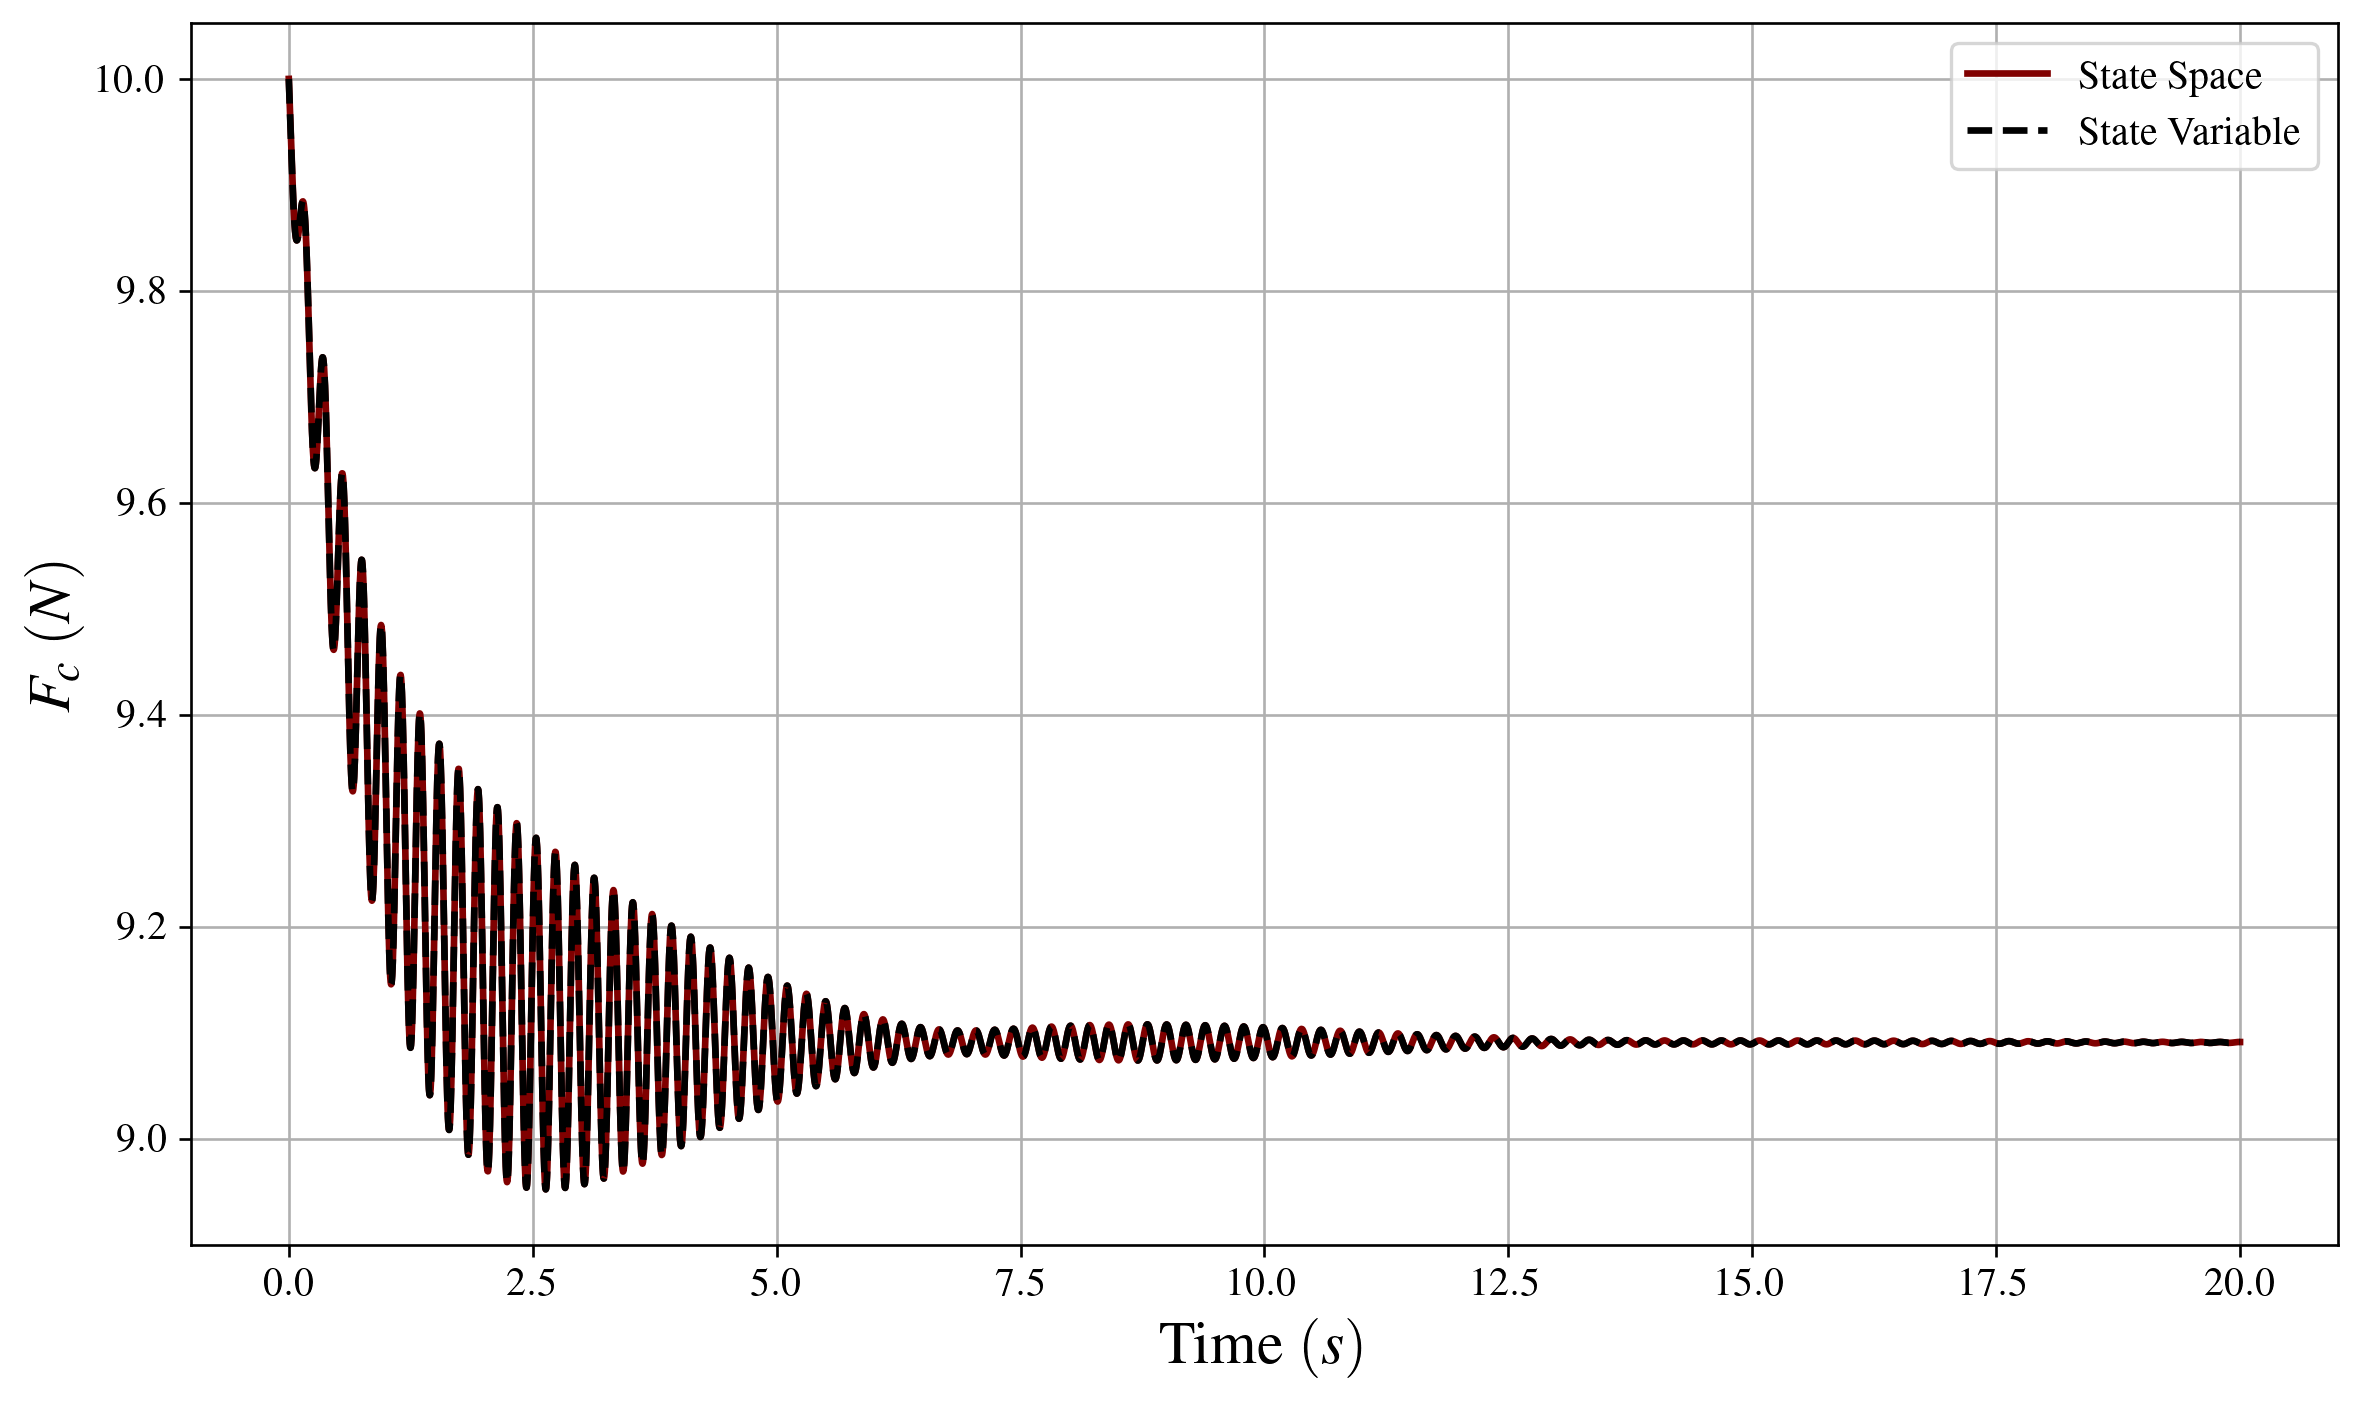

In [11]:
# Getting the contact force using the control package
t_array = np.linspace(0, 20, sol1.t.size)
_, F_c_ = ct.forced_response(ss, T=t_array, U=f_lamb(t_array))

# Here is the solution using the original solution
F_c_original = -b_*v1_ + k1_*d_x_ + f_lamb(t_array)

fig, ax = plt.subplots()
ax.plot(t_array, F_c_, label='State Space')
ax.plot(sol1.t, F_c_original, label='State Variable', ls='--')
ax.set_xlabel('Time $(s)$')
ax.set_ylabel('$F_c$ $(N)$')
ax.legend()
plt.show()

### Part E
The control package has a function to transform this to a transfer function. We can also find the transfer function algebraically with `sympy`.

In [12]:
ct_tf = ct.ss2tf(ss)
ct_tf

TransferFunction(array([1.00e+00, 2.50e+00, 2.00e+03, 3.75e+03, 1.00e+06, 1.25e+06]), array([1.000000e+00, 2.750000e+00, 2.003125e+03, 4.131250e+03,
       1.001875e+06, 1.375000e+06]))

In [13]:
# Getting the symbolic solution
eqs_with_contact = eqs + [sp.Eq(F_c, state_sol[F_c])]

laplace = lambda expr: sp.laplace_transform(expr, t, s, noconds=True)

initial = [
    (d_x.subs(t, 0), 0),
    (d_theta.subs(t, 0), 0),
    (v1.subs(t, 0), 0),
    (v2.subs(t, 0), 0),
    (omega2.subs(t, 0), 0)
]

eqs_s = [sp.Eq(laplace(eq.lhs), laplace(eq.rhs)).subs(initial) for eq in eqs_with_contact]
S_s = [laplace(ex) for ex in list(S)]
sol_s = sp.solve(eqs_s, S_s + [laplace(F_c)], dict=True)[0]
for key, value in sol_s.items():
    display(sp.Eq(key, value.simplify()))

Eq(LaplaceTransform(F_c(t), t, s), (B*J1*k1*s**2 + B*J1*m*s**4 + B*k1*k2 + B*k2*m*s**2 + J1*J2*k1*s**3 + J1*J2*m*s**5 + J1*k1*k2*s + J1*k2*m*s**3 + J2*k1*k2*s + J2*k2*m*s**3)*LaplaceTransform(f(t), t, s)/(B*J1*k1*s**2 + B*J1*m*s**4 + B*b*k1*r**2*s + B*b*m*r**2*s**3 + B*k1*k2 + B*k1*m*r**2*s**2 + B*k2*m*s**2 + J1*J2*k1*s**3 + J1*J2*m*s**5 + J1*k1*k2*s + J1*k2*m*s**3 + J2*b*k1*r**2*s**2 + J2*b*m*r**2*s**4 + J2*k1*k2*s + J2*k1*m*r**2*s**3 + J2*k2*m*s**3 + b*k1*k2*r**2 + b*k2*m*r**2*s**2 + k1*k2*m*r**2*s))

Eq(LaplaceTransform(\Delta x(t), t, s), m*r**2*s*(-B*s - J2*s**2 - k2)*LaplaceTransform(f(t), t, s)/(B*J1*k1*s**2 + B*J1*m*s**4 + B*b*k1*r**2*s + B*b*m*r**2*s**3 + B*k1*k2 + B*k1*m*r**2*s**2 + B*k2*m*s**2 + J1*J2*k1*s**3 + J1*J2*m*s**5 + J1*k1*k2*s + J1*k2*m*s**3 + J2*b*k1*r**2*s**2 + J2*b*m*r**2*s**4 + J2*k1*k2*s + J2*k1*m*r**2*s**3 + J2*k2*m*s**3 + b*k1*k2*r**2 + b*k2*m*r**2*s**2 + k1*k2*m*r**2*s))

Eq(LaplaceTransform(\Delta\theta(t), t, s), r*(-B*k1 - B*m*s**2 - J2*k1*s - J2*m*s**3)*LaplaceTransform(f(t), t, s)/(B*J1*k1*s**2 + B*J1*m*s**4 + B*b*k1*r**2*s + B*b*m*r**2*s**3 + B*k1*k2 + B*k1*m*r**2*s**2 + B*k2*m*s**2 + J1*J2*k1*s**3 + J1*J2*m*s**5 + J1*k1*k2*s + J1*k2*m*s**3 + J2*b*k1*r**2*s**2 + J2*b*m*r**2*s**4 + J2*k1*k2*s + J2*k1*m*r**2*s**3 + J2*k2*m*s**3 + b*k1*k2*r**2 + b*k2*m*r**2*s**2 + k1*k2*m*r**2*s))

Eq(LaplaceTransform(\omega_2(t), t, s), k2*r*(k1 + m*s**2)*LaplaceTransform(f(t), t, s)/(B*J1*k1*s**2 + B*J1*m*s**4 + B*b*k1*r**2*s + B*b*m*r**2*s**3 + B*k1*k2 + B*k1*m*r**2*s**2 + B*k2*m*s**2 + J1*J2*k1*s**3 + J1*J2*m*s**5 + J1*k1*k2*s + J1*k2*m*s**3 + J2*b*k1*r**2*s**2 + J2*b*m*r**2*s**4 + J2*k1*k2*s + J2*k1*m*r**2*s**3 + J2*k2*m*s**3 + b*k1*k2*r**2 + b*k2*m*r**2*s**2 + k1*k2*m*r**2*s))

Eq(LaplaceTransform(v1(t), t, s), r**2*(B*k1*s + B*m*s**3 + J2*k1*s**2 + J2*m*s**4 + k1*k2 + k2*m*s**2)*LaplaceTransform(f(t), t, s)/(B*J1*k1*s**2 + B*J1*m*s**4 + B*b*k1*r**2*s + B*b*m*r**2*s**3 + B*k1*k2 + B*k1*m*r**2*s**2 + B*k2*m*s**2 + J1*J2*k1*s**3 + J1*J2*m*s**5 + J1*k1*k2*s + J1*k2*m*s**3 + J2*b*k1*r**2*s**2 + J2*b*m*r**2*s**4 + J2*k1*k2*s + J2*k1*m*r**2*s**3 + J2*k2*m*s**3 + b*k1*k2*r**2 + b*k2*m*r**2*s**2 + k1*k2*m*r**2*s))

Eq(LaplaceTransform(v2(t), t, s), k1*r**2*(B*s + J2*s**2 + k2)*LaplaceTransform(f(t), t, s)/(B*J1*k1*s**2 + B*J1*m*s**4 + B*b*k1*r**2*s + B*b*m*r**2*s**3 + B*k1*k2 + B*k1*m*r**2*s**2 + B*k2*m*s**2 + J1*J2*k1*s**3 + J1*J2*m*s**5 + J1*k1*k2*s + J1*k2*m*s**3 + J2*b*k1*r**2*s**2 + J2*b*m*r**2*s**4 + J2*k1*k2*s + J2*k1*m*r**2*s**3 + J2*k2*m*s**3 + b*k1*k2*r**2 + b*k2*m*r**2*s**2 + k1*k2*m*r**2*s))

Very large expressions! Note that the denominator is the same across all results. This means we are doing good!

In [14]:
# Only getting the contact force and substituting values
sp_tf = sol_s[laplace(F_c)]/laplace(f)
sp_tf = sp_tf.subs(sub_vals).simplify()
sp_tf

4*(2*s**5 + 5*s**4 + 4000*s**3 + 7500*s**2 + 2000000*s + 2500000)/(8*s**5 + 22*s**4 + 16025*s**3 + 33050*s**2 + 8015000*s + 11000000)

The results are a match.

## Verification of Parts D-E
### Part F

In [15]:
# Taking the inverse laplace to solve for F_c
F_c_s = sp_tf*10/s
# f_c_t = sp.inverse_laplace_transform(F_c_s, s, t)
# f_c_t
F_c_s

40*(2*s**5 + 5*s**4 + 4000*s**3 + 7500*s**2 + 2000000*s + 2500000)/(s*(8*s**5 + 22*s**4 + 16025*s**3 + 33050*s**2 + 8015000*s + 11000000))

That above cell will result in an error due to complexity and even MatLab cannot do this. However, you can get this to work if you represent the function in partial fractions before taking the inverse laplace.

In [16]:
# Get partial fraction representation
F_c_apart = F_c_s.apart(full=True).n().expand()
F_c_apart

-0.10009634615065/(s + 0.379308107105189 + 31.1793861747501*I) - 0.0100016239481903*I/(s + 0.379308107105189 + 31.1793861747501*I) - 0.10009634615065/(s + 0.379308107105189 - 31.1793861747501*I) + 0.0100016239481903*I/(s + 0.379308107105189 - 31.1793861747501*I) + 0.107719953503079/(s + 0.308176874958113 + 32.0682682599475*I) - 0.0102404999000872*I/(s + 0.308176874958113 + 32.0682682599475*I) + 0.107719953503079/(s + 0.308176874958113 - 32.0682682599475*I) + 0.0102404999000872*I/(s + 0.308176874958113 - 32.0682682599475*I) + 0.893843694386069/(s + 1.3750300358734) + 9.09090909090909/s

The above representation is good enough for `sympy` to take the inverse Laplace.

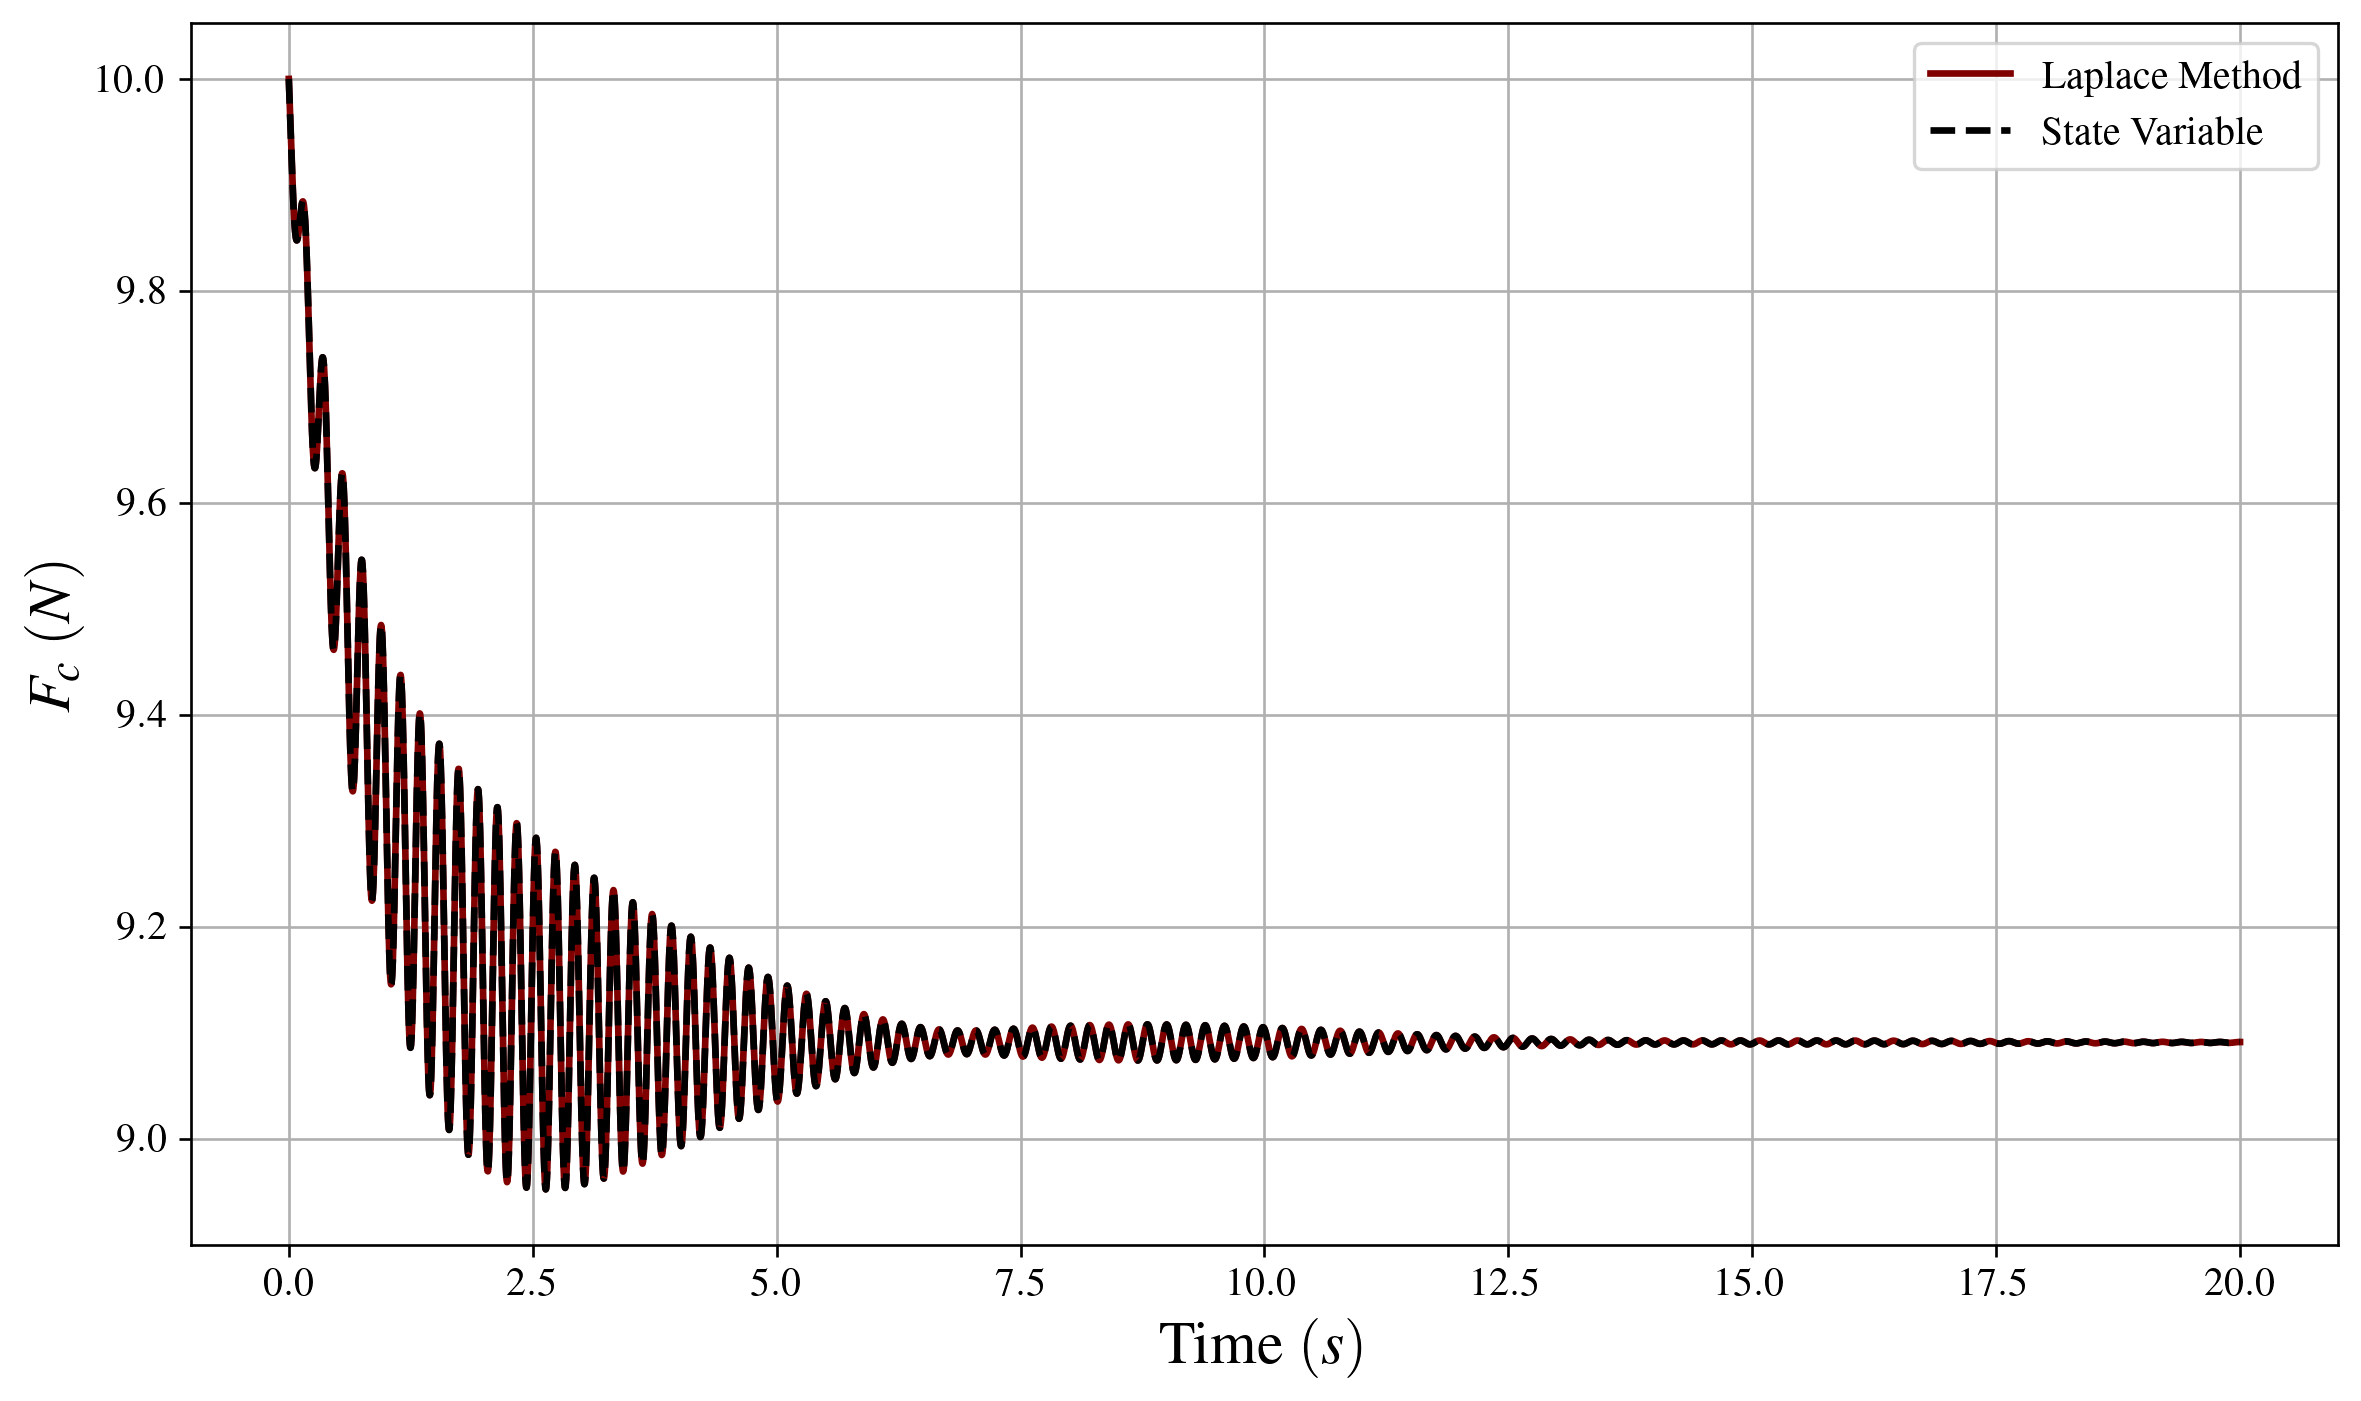

In [17]:
f_c_t = sp.inverse_laplace_transform(F_c_apart, s, t)
f_c_t_lamb = sp.lambdify(t, f_c_t, modules='numpy')

fig, ax = plt.subplots()
ax.plot(t_array, np.real(f_c_t_lamb(t_array)), label='Laplace Method')
ax.plot(sol1.t, F_c_original, label='State Variable', ls='--')
ax.set_xlabel('Time $(s)$')
ax.set_ylabel('$F_c$ $(N)$')
ax.legend()
plt.show()

In [18]:
# Roots of cp
_, cp_den = sp.fraction(sp_tf)
cp_roots = sp.nroots(cp_den)
display(*cp_roots)

-1.37503003587340

-0.379308107105189 - 31.1793861747501*I

-0.379308107105189 + 31.1793861747501*I

-0.308176874958113 - 32.0682682599475*I

-0.308176874958113 + 32.0682682599475*I

We can get the time constant.

In [19]:
# Getting time constant
cp_roots_ = np.complex64(cp_roots)
taus = -1/np.real(cp_roots_)
tau_max = np.max(taus)
float(tau_max)  # dominant root

3.244889736175537

In [20]:
float(4.6*tau_max)

14.926492691040039

The analysis above shows us that the system should reach steady state in about 15 seconds and the graphs confirm this.

In [21]:
# Getting peak to peak oscillation periods
1/np.imag(cp_roots_[1:])*2*np.pi  # seconds

array([-0.2015173 ,  0.2015173 , -0.19593155,  0.19593155], dtype=float32)

Looking at the imaginary component shows us that we should have oscillations from peak to peak at 0.2 second time intervals. The graphs show this as well!